# Transformer Implementation using Pytorch

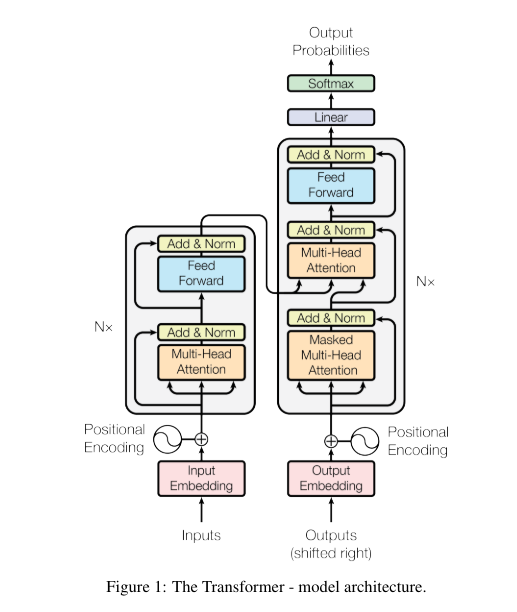

All the blocks are implemented based on the architecture diagram above from the paper.

References :
https://arxiv.org/pdf/1706.03762

https://www.youtube.com/watch?v=ISNdQcPhsts&t=9595s

https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html

Task list:

1. Create Embedding class
2. Create Positional Embedding class
3. Create Multihead attention class (with scaled dot product attention)
4. Create Transformer Encoder block

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

#### Input embedding class :

The input tokens would need to be converted into word embeddings of cretain size. The InputEmbedding class does this for our input tokens. Maintaining naming convention and keeping embedding dimension name as *d_model*. Also, the embeddings are divided by *sqrt(d_model)* as per the paper.

In [ ]:
class InputEmbedding(nn.Module):
  def __init__(self, vocab_size: int, d_model: int):
    super().__init__()
    self.vocab_size = vocab_size
    self.d_model = d_model
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    x = self.embedding(x) * math.sqrt(self.d_model)
    return x

#### Positional Encoding Class:

The positional encoding is created for every position in the sequence length. The output is of the dimension (seq_length,d_model), since each vector of the tokens will be of d_model size, but we will have seq_length positions.

**Good reference** : https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/

**NOTE** : For numerical stability, the Positional Encoding is implemented using log and exp (output remains the same as below formula). Ref https://ai.stackexchange.com/questions/41670/why-use-exponential-and-log-in-positional-encoding-of-transformer





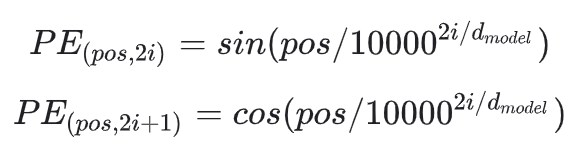

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    #1. Create matrix of shape (seq_len, d_model)
    pos_enc = torch.zeros((seq_len, d_model))

    #2. Create the tensor of shape (seq_len, 1) for each position in the seq_len
    # Since we want to encode the position along the sequence_length, we would create this pos_embedding once and then can boradcast it along the d_model dimension
    # 0 1 2 ... seq_len-1
    position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1)

    #3. The overall formula, for numerical stability, is given as exp(log(PE))
    # ie, sin or cos of --> pos * exp((2*i/d_model)*log(10000))
    #div term is exp((2*i/d_model)*log(10000))) [Notice that only EVEN i positions (from 0 to d_model) are used in the formula]
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * ((math.log(10000.0))/(self.d_model)))

    #4. Fill all even positions (result of (seq_len, 1) and (d_model/2,) matrix multiplication)
    pos_enc[:,0::2] = torch.sin(position * div_term)

    #5. Fill all odd positions (result of (seq_len, 1) and (d_model/2,) matrix multiplication)
    pos_enc[:,1::2] = torch.cos(position * div_term)

    #6. Add the 0th dimension to allow batch size
    pos_enc = pos_enc.unsqueeze(0)

    #7. IMP: Since this is not a learnable weight, but we still want to save it as a part of model state dict, we need to store it in the register buffer
    # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
    # Used for tensors that need to be on the same device as the module.
    self.register_buffer('pos_enc', pos_enc)

  def forward(self, x):
    x = x + self.pos_enc[:, :x.shape[1],:].requires_grad_(False)
    x = self.dropout(x)
    return x


#### Layer Norm Class

Below class applies layer norm for given input batch. This basically normalizes each input based on its own mean and variance.

**NOTE** : In mean function, the dim parameter refers to the dimension which will be collapsed after the operation is performed. Here dim=-1 implies that the (batch_size, seq_len, emb_dim) would be represented as (batch_size,

```
# This is formatted as code
```

seq_len, 1) which would have the mean values for each position in seq_len.

keepdim=True prevents this from happening, maintaining the original dimension info.

eg : a.shape --> torch.Size([128, 4, 5])

a.mean(-1).shape --> torch.Size([128, 4])

a.mean(-1, keepdim=True).shape --> torch.Size([128, 4, 1])



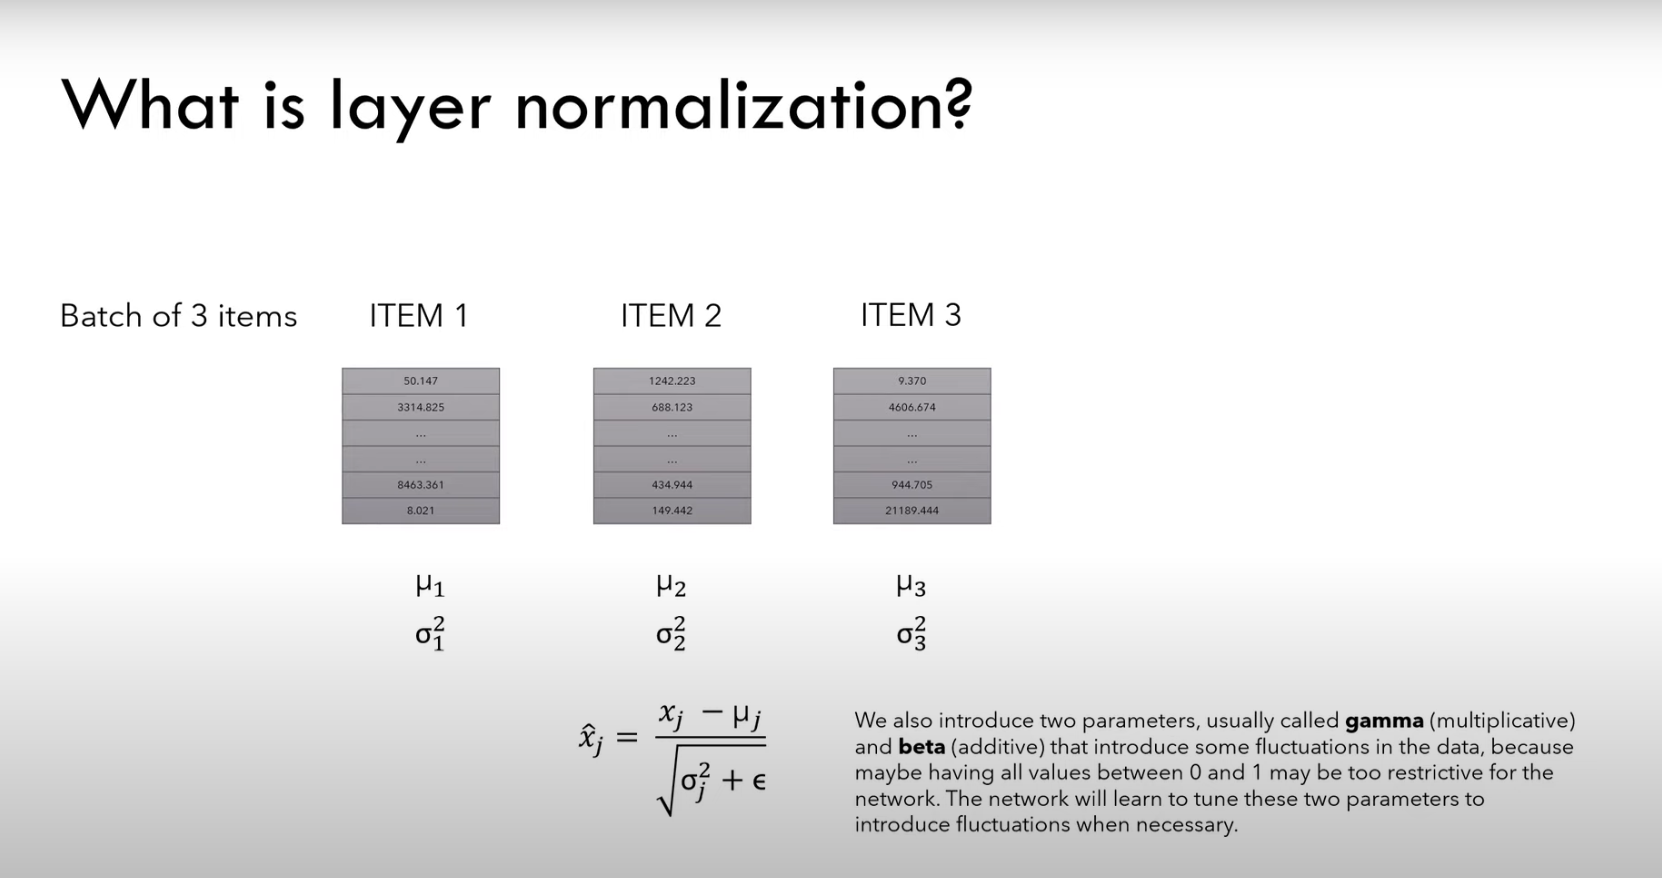

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, epsilon: float = 10**-4) -> None:
    super().__init__()
    self.eps = epsilon
    self.gamma = nn.Parameter(torch.ones([1]))
    self.beta = nn.Parameter(torch.ones([1]))

  def forward(self, x):

    #Calculate the mean and std dev for each input x in the batch
    mean = x.mean(dim=-1, keepdims=True)
    std = x.std(dim=-1, keepdims=True)

    #Apply layer norm, ie x~ = gamma* ((x-mean)/(std+eps)) + beta
    return self.gamma*((x - mean)/(std + self.eps)) + self.beta

#### Feed Forward Layer Block

As per the paper, the d_model is 512 dim and the FC layers are 2048 dims. There are 2 FC layers, ie., 512 -> 2048 and 2048 -> 512



```
FFN(x) = max(0, xW1 + b1)W2 + b2

```




In [ ]:
class FeedForwardBlock(nn.Module):
  def __init__(self, d_model : int, hidden_dim : int, dropout : float):
    super().__init__()
    self.layer_1 = nn.Linear(d_model, hidden_dim)
    self.layer_2 = nn.Linear(hidden_dim, d_model)
    self.dropout = nn.Dropout(dropout)
    self.activation = torch.relu

  def forward(self, x):
    x = self.layer_1(x)
    x = self.activation(x)
    x = self.dropout(x)
    x = self.layer_2(x)
    return x

#### Multihead Attention Block:

For this block, we need the d_model ie. embedding dimension and the n_heads parameter for the number of attention heads. Using d_model and n_heads, we get the dimension for each attention head, which is d_k = (d_model/n_heads).

Also, we would create the Wq, Wk and Wv matrices, to obtain the Q, K and V vectors for each input word and use it for the multiple attention heads.

After the attention mechanism is applied to all the heads, the concatenated result (n_heads*d_v dim) is passed through a linear layer Wo, which projects the result for each word embedding back to d_model dimensions.

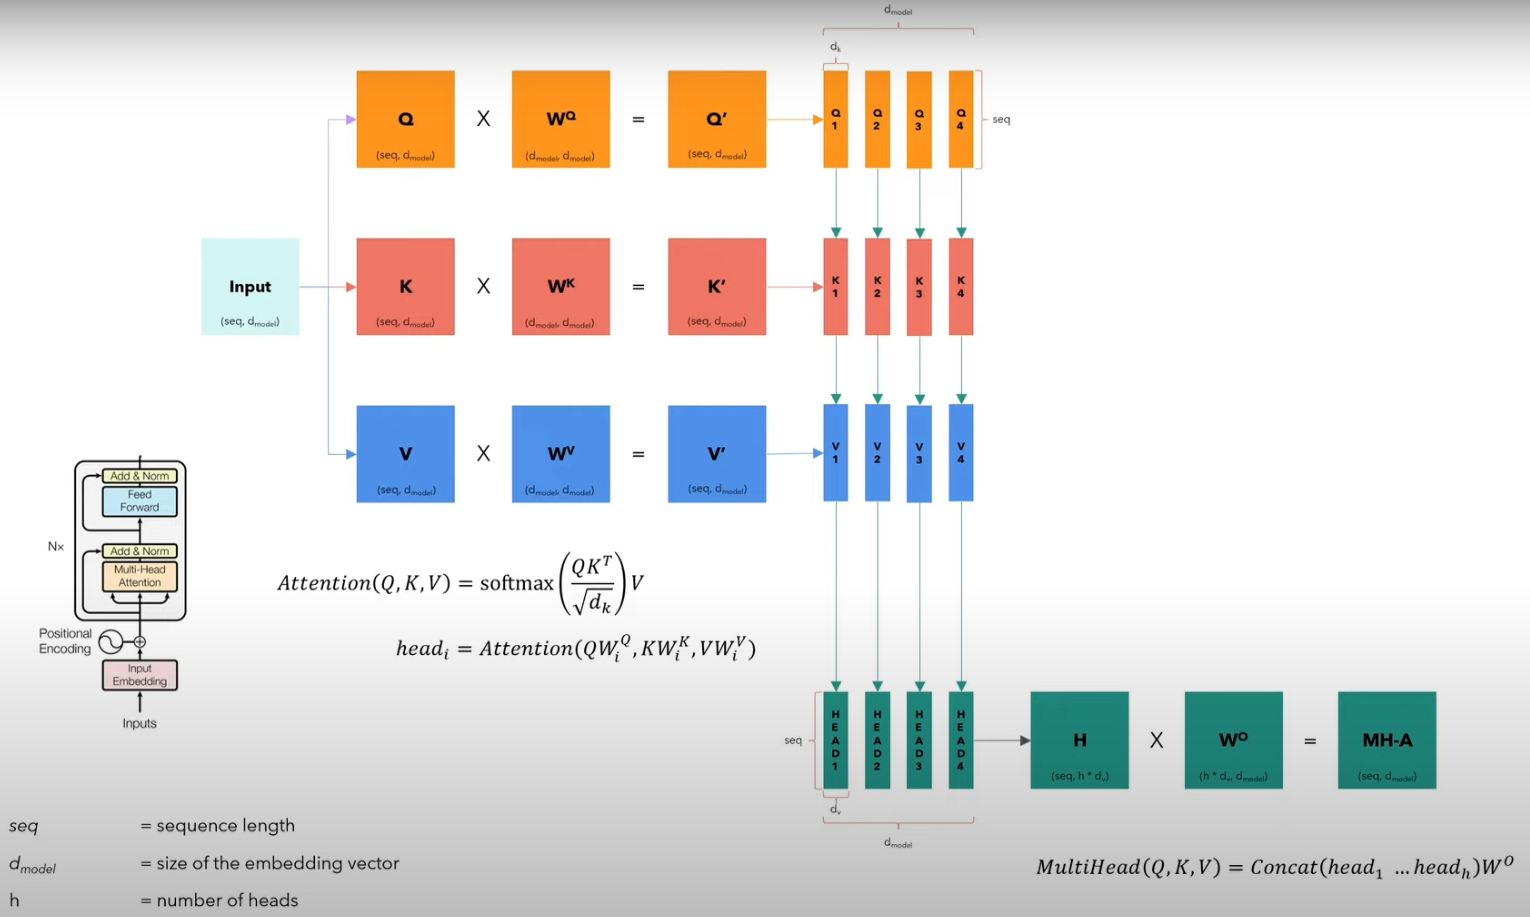

In [ ]:
class MultiheadAttentionBlock(nn.Module):
  def __init__(self, d_model:int, n_heads:int, dropout:float):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads
    assert d_model%n_heads == 0 , "Embedding dimension must be divisible by number of attention heads."

    #// for integer division
    self.d_k = d_model//n_heads

    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)


    self.w_o = nn.Linear(self.d_k*n_heads, d_model)
    self.dropout = nn.Dropout(dropout)

  @staticmethod
  def attention(query, key, value, mask, dropout: nn.Dropout):
    '''
    Function to calculate attention mechanism, ie softmax(q.kT/sqrt(d_k)).v
    Attention mask is to be applied before softmax
    Since this method can be used without the MultiHeadAttention class obkect, hence declared as static method
    '''
    d_k = query.shape[-1]

    #Perform matrix multiplication of query and key matrix (only along seq_len, d_k dimensions)
    attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k) # batch, n_heads, seq_len, seq_len

    #NOTE: ATTENTION MASK MUST HAVE LAST DIMENSION AS SEQ_LEN to fit to the attention scores

    if mask is not None:
      #Wherever mask==0, replace it with -1e9
      attention_scores.masked_fill_(mask==0, -1e9)

    #Apply softmax across the d_k dimension (dim=-1)
    attention_scores = F.softmax(attention_scores, dim=-1) #batch, n_heads, seq_len, seq_len

    if dropout is not None:
      attention_scores = dropout(attention_scores) #batch, n_heads, seq_len, seq_len

    #Returning attention scores as well for visualization
    return (attention_scores @ value) , attention_scores #batch, n_heads, seq_len, d_k



  def forward(self, k, q, v, mask):
    '''
    The input has separate k,q,v as parameters because:
    1. In Encoder, the input x itself is passed as input for k,q,v
    2. In Decoder, the k and v vectors are from the encoder in the Encoder-Decoder attention part

    #The mask is used only for decoder, to use the masked multihead attention functionality and mask future tokens. This is also used if we stack multiple sequences with different lengths into a batch.
    To still benefit from parallelization in PyTorch, we pad the sentences to the same length and mask out the padding tokens during the calculation of the attention values.
    '''

    query = self.w_q(q) #batch, seq_len, d_model
    key = self.w_k(k) #batch, seq_len, d_model
    value = self.w_v(v) #batch, seq_len, d_model

    #Change the shape to (batch, seq_len, h_heads, d_k)
    #Also, transpose the shape to (batch, n_heads, seq_len, d_k), since we want the n_heads dim to be outside
    query = query.view(query.shape[0], query.shape[1], self.n_heads, self.d_k).transpose(1,2)
    key = key.view(key.shape[0], key.shape[1], self.n_heads, self.d_k).transpose(1,2)
    value = value.view(value.shape[0], value.shape[1], self.n_heads, self.d_k).transpose(1,2)

    #Compute attention
    x, self.attention_scores = MultiheadAttentionBlock.attention(query, key, value, mask, self.dropout) #batch, n_heads, seq_len, d_k

    #Before the final linear layer (w_o), we need to get the dimensions back to (batch, seq_len, n_heads, d_k) and then concat to get (batch, seq_len, d_model)
    #batch, n_heads, seq_len, d_k -> batch, seq_len, n_heads, d_k
    x = x.transpose(1,2)

    #When you call contiguous(), it makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.
    #Normally you don't need to worry about this. You're generally safe to assume everything will work, and wait until you get a RuntimeError: input is not contiguous.
    #batch, seq_len, n_heads, d_k -> batch, seq_len, d_model
    x = x.contiguous().view(x.shape[0], x.shape[1], self.d_model)

    return self.w_o(x)




#### Residual Connection

There are residual connections which does the following:
1. Take the previous layer output --> (x)
2. Pass this to a sub layer (MultiheadAttention in out case) --> MHA(x)
3. Add the value to the sublayer output --> x+MHA(x)
4. Pass through LayerNorm --> LayerNorm(x+MHA(x))

This overall process completes till the Add & Norm portion of the blocks from the architecture.

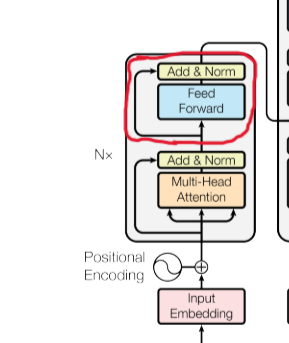

In [ ]:
class ResidualConnection(nn.Module):
  def __init__(self, dropout:float):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNorm()

  def forward(self, x, sub_layer):
    '''
    For previous layer output ie. x, and sublayer (MHA), perform LayerNorm, followed by MHA and dropout, followed by residual connection (add input x to this).
    Sequence of operations (LayerNorm, MHA) changed here as per other referred implementations.
    '''
    x = x + self.dropout(sub_layer(self.norm(x)))
    return x

#### Encoder Block

We will create the Encoder Block using the MultiHeadAttention, ResidualConnection, FeedForwardBlock and the LayerNorm

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, attention_block: MultiheadAttentionBlock, feed_forward_block:FeedForwardBlock, dropout: float):
    super().__init__()
    self.self_attention_block = attention_block
    self.dropout = nn.Dropout(dropout)
    #We have 2 residual connections in 1 encoder block. Storing then in Modulelist
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for i in range(2)])
    self.feed_forward = feed_forward_block

  def forward(self, x, src_mask):
    '''
    NOTE: Here, the second input to the residual_connection is a LAMBDA FUNCTION, ie, we send the one liner function, which will execute any input given to it in the ResidualConnection forward method as defined
    NOTE: The second residual connection does not require a lambda function, as feed_forward layer anyway takes just 1 input (which will be passed to it in the residual_connection itself)
    '''
    x = self.residual_connections[0](x, lambda y : self.self_attention_block(y, y, y, src_mask))
    x = self.residual_connections[1](x, self.feed_forward)
    return x

### Transformer Encoder

Now, we can stack multiple Encoder blocks to get the transformer encoder. This can have n Encoder blocks, followed by LayerNorm at the end.

In [ ]:
class Encoder(nn.Module):
  def __init__(self, layers:nn.ModuleList):
    super().__init__()
    self.layers = layers
    self.norm = LayerNorm()

  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

#### Decoder Block

We will use the components from before to create the Decoder block. The changes in Decoder block in comparison to Encoder block are as follows:

1. 3 Residual connections
2. Cross attention in addition to self attention (uses key and value vectors from Encoder final output, query from Decoder input)

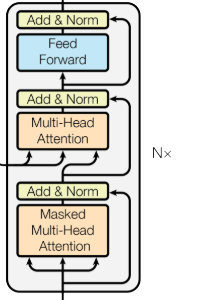

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, self_attention_block:MultiheadAttentionBlock, cross_attention_block:MultiheadAttentionBlock, feed_forward_block:FeedForwardBlock, dropout:float):
    super().__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward = feed_forward_block
    self.dropout = nn.Dropout(dropout)
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for i in range(3)])

  def forward(self, x, encoder_output, src_mask, tgt_mask):
    '''
    We require the encoder output, as the cross attention will use the key and value vectors from this output.
    Also, the target mask will also bee needed, to perform masking on future tokens in the decoder
    '''

    x = self.residual_connections[0](x, lambda y : self.self_attention_block(y, y, y, tgt_mask))
    #The cross attention layer will take current input only for QUERY. The key and values are computed using Encoder layer output.
    x = self.residual_connections[1](x, lambda y : self.cross_attention_block(y, encoder_output, encoder_output, src_mask))
    x = self.residual_connections[2](x, self.feed_forward)
    return x

### Transformer Decoder

Now, we can stack multiple Decoder blocks to get the transformer decoder. This can have n Decoder blocks, followed by LayerNorm at the end.

In [ ]:
class Decoder(nn.Module):
  def __init__(self, layers:nn.ModuleList):
    super().__init__()
    self.layers = layers
    self.norm = LayerNorm()

  def forward(self, x, encoder_output, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, encoder_output, src_mask, tgt_mask)
    return self.norm(x)



### Final Projection (Linear) layer

The Decoder output would be (during training) of (batch_size, seq_len, d_model) dims. Since we need a prediction of the next token from the decoder output for each token in seq_len, we need to modify this output using a linear layer so that each seq_len has vocab_size number of outputs, ie., the dimension changes to (batch_size, seq_len, vocab_size)

Additionally, softmax would also be applied across last dimension, to get output probabilities for each token in seq_len.

In [ ]:
class ProjectionLayer(nn.Module):
  def __init__(self, d_model:int, vocab_size:int):
    super().__init__()
    self.linear = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    '''
    Converts (batch_size, seq_len, d_model) --> (batch_size, seq_len, vocab_size)
    Apply softmax to get probabilities for each seq_len
    '''
    x = self.linear(x)
    return torch.log_softmax(x, dim=-1)

## Transformer Model Block

Now, we can create the transformer model class, which will incorporate the input processing, entire Encoder and Decoder stack, and output generation.

**Few important points:**
1. We dont use a forward method here, instead, we use a function for encoding and a function for decoding.
2. The reason is that during inference, the encoder output need not be generated again and again.
3. We will create a separate function later which can incorporate all the classes from the above and perform the transformer operation end to end.

In [ ]:
class Transformer(nn.Module):
  def __init__(self, encoder: Encoder, decoder: Decoder, src_emb: InputEmbedding, tgt_emb: InputEmbedding, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_emb = src_emb
    self.tgt_emb = tgt_emb
    self.src_pos = src_pos
    self.tgt_pos = tgt_pos
    self.projection_layer = projection_layer

  def encode(self, src, src_mask):
    src = self.src_emb(src)
    src = self.src_pos(src)
    src = self.encoder(src, src_mask)
    return src

  def decode(self, encoder_output, src_mask, tgt, tgt_mask):
    tgt = self.tgt_emb(tgt)
    tgt = self.tgt_pos(tgt)
    tgt = self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    return tgt

  def project(self, decoder_output):
    return self.projection_layer(decoder_output)



### Function to perform the end to end Transformer operation

We would create a function which would combine the individual components defined above, so that we can perform the language translation task.

In [ ]:
def build_transformer(src_vocab_size:int, tgt_vocab_size:int, src_seq_len: int, tgt_seq_len: int, d_model:int = 512, N:int=6, n_heads:int =8, dropout:float = 0.01, d_ff_hidden: int=2048):
  '''
  Takes all the inputs required for the Transformer initialization and returns a Transformer object.
  '''
  src_emb = InputEmbedding(src_vocab_size, d_model)
  tgt_emb = InputEmbedding(tgt_vocab_size, d_model)

  src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
  tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

  projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

  encoder_layers = []
  for _ in range(N):
    #Create attn_block, ff_block and use it to make encoder block
    self_attn_block = MultiheadAttentionBlock(d_model, n_heads, dropout)
    ff_block = FeedForwardBlock(d_model, d_ff_hidden, dropout)
    encoder_block = EncoderBlock(self_attn_block, ff_block, dropout)
    encoder_layers.append(encoder_block)

  #Create Encoder object using the encoder blocks stacked
  encoder = Encoder(nn.ModuleList(encoder_layers))

  decoder_layers = []
  for _ in range(N):
    #Create attn_block, ff_block and use it to make decoder block
    self_attn_block = MultiheadAttentionBlock(d_model, n_heads, dropout)
    cross_attn_block = MultiheadAttentionBlock(d_model, n_heads, dropout)
    ff_block = FeedForwardBlock(d_model, d_ff_hidden, dropout)
    decoder_block = DecoderBlock(self_attn_block, cross_attn_block, ff_block, dropout)
    decoder_layers.append(decoder_block)

  #Create Decoder object using the decoder blocks stacked
  decoder = Decoder(nn.ModuleList(decoder_layers))

  #Create transformer object
  transformer = Transformer(encoder, decoder, src_emb, tgt_emb, src_pos, tgt_pos, projection_layer)

  #Initialize all the the weights of the transformer using Xavier initialization
  for p in transformer.parameters():
    if p.dim()>1:
      nn.init.xavier_uniform_(p)

  return transformer




## Dataset processing and Tokenization

The task to be performed using the Transformer model is English to Hindi Language Translation. For this purpose, we would use the IITB English-Hindi Dataset (https://huggingface.co/datasets/cfilt/iitb-english-hindi). The Tokenization of the sentences would be performed at Word Level, using Huggingface Tokenization library.

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [ ]:
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from tqdm import tqdm
import warnings
from torch.utils.tensorboard import SummaryWriter


#### Utility functions for tokenization and related tasks

Functions to create the Dataset object for source and target language, build tokenizer and to get the required tokenizer format for sending the data into the model.

In [ ]:
class BilingualDataset(Dataset):
  '''
  Dataset object for Language Translation task. The operations performed would be as follows:
  1. __init__ : Initialize the data, tokenizers and the max seq_len for the data
  2. __getitem__ : Returns the encoder_input, decoder_input, encoder_mask, decoder_mask and the labels(output)
  3. __len__ : Returns the dataset size
  '''

  def __init__(self, dataset, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
    super().__init__()
    self.dataset = dataset
    self.tokenizer_src = tokenizer_src
    self.tokenizer_tgt = tokenizer_tgt
    self.src_lang = src_lang
    self.tgt_lang = tgt_lang
    self.seq_len = seq_len

    #Store the SOS, EOS and PAD token ids as they will be frequently used
    self.sos_token = torch.tensor([tokenizer_tgt.token_to_id('[SOS]')], dtype = torch.int64)
    self.eos_token = torch.tensor([tokenizer_tgt.token_to_id('[EOS]')], dtype = torch.int64)
    self.pad_token = torch.tensor([tokenizer_tgt.token_to_id('[PAD]')], dtype = torch.int64)

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    '''
    For the given index, the source and target sentence must be:
    1. Tokenized
    2. Padded
    3. Add SOS and EOS where relevant
    4. Create the attention mask for encoder(mask padded words) and decoder(upper triangular matrix to mask future tokens and padded words)

    Cases:
    1. For Encoder input (src) : Perform PAD, SOS, EOS for the sentence
    2. For Decoder input (tgt) : Perform PAD and SOS (no need of EOS)
    3. For Decoder output (label) : Perform PAD and EOS (no need of SOS)

    Returns the encoder_input, decoder_input, encoder_mask, decoder_mask and the labels(output)
    '''

    src_text = self.dataset['translation'][index][self.src_lang]
    tgt_text = self.dataset['translation'][index][self.tgt_lang]

    enc_input_tokens = self.tokenizer_src.encode(src_text).ids
    dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

    pad_tokens_src = self.seq_len - len(enc_input_tokens) - 2 #-2 for SOS and EOS
    pad_tokens_tgt = self.seq_len - len(dec_input_tokens) - 1 #-1 for SOS or EOS (different for decoder_input and output)

    #PAD tokens count cannot be less than 0. It means SOS or EOS string or both cannot be accomodated
    if pad_tokens_src < 0 or pad_tokens_tgt < 0:
      raise ValueError('Sentence length is too long. Not able to accomodate SOS and EOS tokens.')

    #Create encoder and decoder input, output by concatenating Tensors of tokens, sos, eos and pad
    encoder_input = torch.cat([
        self.sos_token,
        torch.tensor(enc_input_tokens, dtype=torch.int64),
        self.eos_token,
        torch.tensor([self.pad_token]*pad_tokens_src, dtype=torch.int64)
        ])
    decoder_input = torch.cat([
        self.sos_token,
        torch.tensor(dec_input_tokens, dtype=torch.int64),
        torch.tensor([self.pad_token]*pad_tokens_tgt, dtype=torch.int64)
        ])
    decoder_output = torch.cat([
        torch.tensor(dec_input_tokens, dtype=torch.int64),
        self.eos_token,
        torch.tensor([self.pad_token]*pad_tokens_tgt, dtype=torch.int64)
        ])

    #Check if the final sequence length of the text matches the required sequence length
    assert encoder_input.shape[0] == self.seq_len
    assert decoder_input.shape[0] == self.seq_len
    assert decoder_output.shape[0] == self.seq_len

    #Create encoder mask : We do not want the attention mechanism to work on the PAD tokens.
    #Encoder Mask will have 1 on valid tokens and 0 at PAD tokens
    #Also, add additional dimensions (using unsqueeze) for batch size and seq length (ie final dim = (1,1,seq_len))
    encoder_mask = (encoder_input!=self.pad_token).unsqueeze(0).unsqueeze(0).int() #(1,1,seq_len)

    #Create decoder mask : Hide PAD tokens and mask future tokens (CAUSAL MASK)
    #We need torch triu function to create an upper triangular matrix to do the same for us
    #PROCESS:
    #1. Create the simple attention mask as for encoder (1,1,seq_len)
    #2. Create a CAUSAL MASK, which hides next tokens (1, seq_len, seq_len) --> eg : [[1 0 0],[1 1 0],[1 1 1]]
    #3. Perform logical AND of 1 and 2, to obtain the decoder mask
    decoder_mask = (decoder_input!=self.pad_token).unsqueeze(0).unsqueeze(0).int() #(1,1,seq_len)
    decoder_causal_mask = causal_mask(decoder_input.shape[0]) #(1,seq_len,seq_len)
    decoder_mask = decoder_mask & decoder_causal_mask #(1,seq_len,seq_len)


    #Return a dictionary of values for the given index
    return {
        'encoder_input' : encoder_input, #(seq_len)
        'decoder_input' : decoder_input, #(seq_len)
        'encoder_mask' : encoder_mask, #(1,1,seq_len)
        'decoder_mask' : decoder_mask, #(1,seq_len,seq_len)
        'label' : decoder_output, #(seq_len)
        'src_text' : src_text,
        'tgt_text' : tgt_text
    }


In [ ]:
def causal_mask(seq_len):
  '''
  Function to create a causal mask, given the sequence length.
  Uses the triu function of pytorch to create a upper triangular matrix of required dimensions
  https://pytorch.org/docs/stable/generated/torch.triu.html
  '''
  mask = torch.ones(1, seq_len, seq_len)

  #We would use triu to set everything below the diagonal (including diagonal) to 0, and everything above it to 1 (later will just flip this matrix while returning)
  #Set diagonal=1, since we want the diagonal as 1 in final output (hence make the diagonal values as 0 now)
  mask = torch.triu(mask, diagonal=1).type(torch.int)

  #Flip all 0's and 1's and return
  return mask==0

In [ ]:
def get_config():
  return {
      'batch_size' : 8,
      'num_epochs' : 2,
      'lr' : 10**-4,
      'seq_len' : 2200,
      'd_model' : 256,
      'src_lang' : 'en',
      'tgt_lang' : 'hi',
      'model_folder' : 'weights',
      'model_basename' : 'tmodel_',
      'preload' : None,
      'tokenizer_file' : "tokenizer_{0}.json",
      'experiment_name' : 'runs/tmodel'
  }

def get_weights_file_path(config, epoch:str):
  model_folder = config['model_folder']
  model_basename = config['model_basename']
  model_filename = model_basename+epoch+'.pt'
  return str(Path('/content/drive/MyDrive/Colab projects/LLM related/Transformer from scratch')/model_folder/model_filename)

In [ ]:

def get_all_sentences(dataset, lang):
  '''
  Returns the sentences in the datset one by one (iterating over the sentences of a lang)
  '''
  for item in dataset:
    yield item['translation'][lang]


def get_or_build_tokenizer(config, dataset, lang):
  '''
  Returns a tokenizer object. If tokenizer object already created, return it by loading from save file, else create a new object, save it and return.
  https://github.com/huggingface/tokenizers
  '''

  tokenizer_path = Path(config['tokenizer_file'].format(lang))
  if not Path.exists(tokenizer_path):
    #Create tokenizer and save in the tokenizer path
    #Use huggingface tokenizer library and related functions to create tokenizer for dataset
    tokenizer = Tokenizer(WordLevel(unk_token = "[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=['[UNK]','[PAD]','[SOS]','[EOS]'], min_frequency=2)
    tokenizer.train_from_iterator(get_all_sentences(dataset, lang), trainer=trainer)
    tokenizer.save(str(tokenizer_path))
  else:
    tokenizer = Tokenizer.from_file(str(tokenizer_path))
  return tokenizer


def get_dataset(config):
  '''
  1. Download the required dataset from huggingface
  2. Get the train-val-test split if not already done
  3. Get the tokenizers for the source and target language (from get_or_build_tokenizer function above)
  4. Create the Torch Dataset object for the source and target dataset using the tokenizer and the input source and target text data
  5. Get the DataLoader objects and return the Dataloader and tokenizer objects for source and target
  '''
  dataset_train = load_dataset("cfilt/iitb-english-hindi", split='train')
  dataset_val = load_dataset("cfilt/iitb-english-hindi", split='validation')
  dataset_test = load_dataset("cfilt/iitb-english-hindi", split='test')
  print(f"Length of training set = {len(dataset_train)}")
  print(f"Length of validation set = {len(dataset_val)}")
  print(f"Length of test set = {len(dataset_test)}")

  tokenizer_src = get_or_build_tokenizer(config, dataset_train, config['src_lang'])
  tokenizer_tgt = get_or_build_tokenizer(config, dataset_train, config['tgt_lang'])

  train_data = BilingualDataset(dataset_train, tokenizer_src, tokenizer_tgt, config['src_lang'], config['tgt_lang'], config['seq_len'])
  val_data = BilingualDataset(dataset_val, tokenizer_src, tokenizer_tgt, config['src_lang'], config['tgt_lang'], config['seq_len'])
  test_data = BilingualDataset(dataset_test, tokenizer_src, tokenizer_tgt, config['src_lang'], config['tgt_lang'], config['seq_len'])

  #Find the max source and target sequence length
  max_len_src = 0
  max_len_tgt = 0

  for item in dataset_train:
    src_ids = tokenizer_src.encode(item['translation'][config['src_lang']]).ids
    tgt_ids = tokenizer_tgt.encode(item['translation'][config['tgt_lang']]).ids
    max_len_src = max(max_len_src, len(src_ids))
    max_len_tgt = max(max_len_tgt, len(tgt_ids))

  print(f"Max sequence length for source : {max_len_src}")
  print(f"Max sequence length for target : {max_len_tgt}")

  #Create Dataloaders, shuffle only for train data
  #Set batch size = 1 for validation and test data
  train_dataloader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
  test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
  val_dataloader = DataLoader(val_data, batch_size=1, shuffle=False)

  return train_dataloader, test_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt


### Functions to build and train Transformer model

In [ ]:
def get_model(config, src_vocab_size, tgt_vocab_size):
  return build_transformer(src_vocab_size, tgt_vocab_size, config['seq_len'], config['seq_len'], config['d_model'], N=2, n_heads=8, dropout=0.01, d_ff_hidden=256)

def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  random.seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def train_model(config):

  set_seed(132)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  #Create the model path if it does not exist already
  Path(config['model_folder']).mkdir(parents=True, exist_ok=True)

  #Get the dataset and tokenizer objects
  train_dataloader, test_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_dataset(config)

  #Get the Transformer model object, send to device
  model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size())
  model = model.to(device)

  #Create optimizer and loss object
  optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], eps=1e-9)

  #For the Cross Entropy loss, use Label Smoothing as well to ensure that learning over the data is better.
  #0.1 Label smoothing indicates that 0.1 of the score would be distributed amongst other values
  loss_fn = torch.nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

  initial_epoch = 0
  global_step=0
  #Check if any epoch needs to be preloaded (to resume training from some epoch)
  if config['preload']:
    model_filename = get_weights_file_path(config, config['preload'])
    print(f'Preloading weights from {model_filename}')
    state = torch.load(model_filename)
    optimizer.load_state_dict(state['optimizer_state_dict'])
    initial_epoch = state['epoch']+1
    global_step = state['global_step']

  #Tensorboard setup for logging
  writer = SummaryWriter(config['experiment_name'])

  #Training code for Transformer
  for epoch in range(initial_epoch, config['num_epochs']):


    batch_iterator = tqdm(train_dataloader, desc=f'Epoch : {epoch:02d}')
    for batch in batch_iterator:
      model.train()

      encoder_input = batch['encoder_input'].to(device) #(B,seq_len)
      decoder_input = batch['decoder_input'].to(device) #(B,seq_len)
      encoder_mask = batch['encoder_mask'].to(device) #(B,1,1,seq_len) --> Because same mask for each entry in seq_len of a sentence (pad tokens masked)
      decoder_mask = batch['decoder_mask'].to(device) #(B,1,seq_len,seq_len) --> Because causal mask ensures we dont see future tokens for each seq_len

      encoder_output = model.encode(encoder_input, encoder_mask) #(B, seq_len, d_model)
      decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) #(B,seq_len,d_model)
      proj_output = model.project(decoder_output) #(B,seq_len, tgt_vocab_size)

      labels = batch['label'].to(device) #(B,seq_len)

      #The input format for CELoss is :
      #Output logits : (B,C)
      #Target labels : (B)
      #B: Batch size, C: Num classes
      #proj_output.view(-1, tokenizer_tgt.get_vocab_size()) --> Changes shape from (B, seq_len, tgt_vocab_size) to (B*seq_len, tgt_vocab_size)
      #labels.view(-1) --> Changes shape from (B,seq_len) to (B)
      loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), labels.view(-1))

      #Add loss to the description of tqdm
      batch_iterator.set_postfix('Loss : f{loss.item():6.3f}')

      #Add to tensorboard writer
      writer.add_scaler('train_loss', loss.item(), global_step)
      writer.flush()

      #Loss backpropagation and weight update
      loss_fn.backward()
      optimizer.step()
      optimizer.zero_grad()

      #Run validation for 2 examples
      run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda text: batch_iterator.write(text), num_examples=2)

      global_step+=1

    #Save the model state
    model_filename = get_weights_file_path(config, f'{epoch:02d}')
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'global_step' : global_step
    }, model_filename)


### Validation loop code

This is different from training loop for the following reasons:

1.  During training, the Decoder input for a sentence can be processed at once (parallely) for the entire sequence length (since Teacher forcing is used and we dont need models predictions)
2. During inference, the Decoder input needs to be processed iteratively, till we reach max_seq_len or till [EOS] is predicted.

**NOTE:** There is also the KV cache concept which applies to caching the KV vectors for the models predictions during the processing of query Qi (not implemented here)

In [ ]:
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):

  sos_token = tokenizer_tgt.token_to_id['SOS']
  eos_token = tokenizer_tgt.token_to_id['EOS']

  #Compute the encoder output once
  #Now, greedily compute the decoder outputs one by one
  encoder_output = model.encoder(source, source_mask)

  #Initialize decoder input with sos token
  decoder_input = torch.empty((1,1)).fill_(sos_token).type_as(source).to(device)

  while True:

    if decoder_input.shape[1]==max_len:
      break

    #Construct mask for current decoder input size
    decoder_mask = causal_mask(decoder_input.shape[1]).type_as(source_mask).to(device)

    output = model.decoder(encoder_output, source_mask, decoder_input, decoder_mask)

    #Get probabilities only for the last token in current decoder output sequence length
    probabilities = model.project(output[:,-1])

    #Next token is the one with mac probability (greedy search)
    _, next_token = torch.max(probabilities, dim=1)

    #Add this to the decoder input sequence for next word prediction
    decoder_input = torch.cat(decoder_input, torch.empty(1,1).fill_(next_token.item()).type_as(source).to(device), dim=1)

    if next_token == eos_token:
      break

  #Remove batch dim before sending (batch is 1 for val data)
  return decoder_input.squeeze(0)



def run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, num_examples=2):
  '''
  Runs the validation loop for val_dataloader. Note that the val dataloader has batch size 1.
  Also, functions like primt_msg used here, since the training loop uses tqdm which would log onto console, and we dont want to disturb that.
  '''
  model.eval()
  count=0

  source_text = []
  expected = []
  predicted = []

  with torch.no_grad():
    for batch in val_dataloader:
      count+=1

      #Get Encoder output for current sentence
      encoder_input = batch['encoder_input'].to(device)
      encoder_mask = batch['encoder_mask'].to(device)
      #Confirm batch size == 1
      assert encoder_input.shape[0] == 1, "Batch size must be 1 for validation"

      decoder_output = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokeniizer_tgt, max_len, device)

      src_text = batch['src_text'][0]
      tgt_text = batch['tgt_text'][0]
      pred_text = tokenizer_tgt.decode(decoder_output.detach().cpu().numpy())
      source_text.append(batch['src_text'][0])
      expected.append(batch['tgt_text'][0])
      predicted.append(pred_text)

      #Printing using print_msg, as we dont want to disturb tqdm logging on the console in training loop
      print_msg('-'*80)
      print_msg(f'Source text : {src_text}')
      print_msg(f'Target text : {tgt_text}')
      print_msg(f'Predicted text : {pred_text}')


      if num_examples == count:
        break





### Model training

In [ ]:
if __name__=='__main__':
  warnings.filterwarnings('ignore')
  config = get_config()
  train_model(config)